In [2]:
import os
import sys
sys.path.insert(1, '../mdai/')

import shutil
from random import randint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn 
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision
from torch.autograd import Variable
from torchsummary import summary
import segmentation_models_pytorch as smp

from PIL import Image
import cv2
import albumentations as alb # A

import time
import os
from tqdm.notebook import tqdm
from workspace import paths_get, paths_join
from mdai_odd_data_wrangling import OpticDiscDrusenDataset

import warnings
warnings.filterwarnings('ignore')

## Sort out the paths required

In [3]:
DATA  = 'mdai-odd'
IMAGE = 'image'
MASK  = 'mask'

base_dir, data_dir, _, _, _ = paths_get('oct2l')
data_dir = paths_join(data_dir, DATA)

'''
os.chdir(data_dir)
os.rename('images_with_masks_mdai', IMAGE)
os.rename('mdai_labelled_data', MASK)
os.chdir(base_dir)
'''

# for me only.

bdots


"\nos.chdir(data_dir)\nos.rename('images_with_masks_mdai', IMAGE)\nos.rename('mdai_labelled_data', MASK)\nos.chdir(base_dir)\n"

import id_map to link images and masks later

In [4]:
id_map = pd.read_csv(paths_join(data_dir, 'id_map.csv'))
id_map = id_map[['id', 'Slice_ODD_id', 'labelName']]

display(id_map.head())

print('Total images: ', id_map.id.nunique())

for label_name in id_map['labelName'].unique():
    print('Number of %s: %d' % (
        label_name, id_map[id_map['labelName']==label_name]['id'].nunique()))

,id,Slice_ODD_id,labelName
0,A_Km5eJK,56_ODD-245_OS,Drusen
1,A_K0a9yV,56_ODD-245_OS,Drusen
2,A_VovNDK,56_ODD-245_OS,Drusen
3,A_gjq2PL,40_ODD-245_OS,Drusen
4,A_KAkM1L,37_ODD-245_OS,Drusen


Total images:  1754
Number of Drusen: 509
Number of Blood vessel: 398
Number of Hyperreflective Line: 847


In [5]:
IMAGE_PATH = paths_join(data_dir, IMAGE)
MASK_PATH = paths_join(data_dir, MASK)

print('IMAGE_PATH: %s' % IMAGE_PATH)
print('MASK_PATH: %s' % MASK_PATH)

n_classes = 3

x_trainval, x_test = train_test_split(id_map['id'].values, test_size=0.2, random_state=42)
x_train, x_val = train_test_split(x_trainval, test_size=0.25, random_state=42)
print('\n')
print('x_train  : %.1f' % (len(x_train)/id_map.id.nunique()))
print('x_test   : %.1f' % (len(x_test)/id_map.id.nunique()))
print('x_val    : %.1f' % (len(x_val)/id_map.id.nunique()))

IMAGE_PATH: /Users/miaomiaoyu/workspace/oct2l/data/mdai-odd/image
MASK_PATH: /Users/miaomiaoyu/workspace/oct2l/data/mdai-odd/mask


x_train  : 0.6
x_test   : 0.2
x_val    : 0.2


Show an example of image and mask overlaid

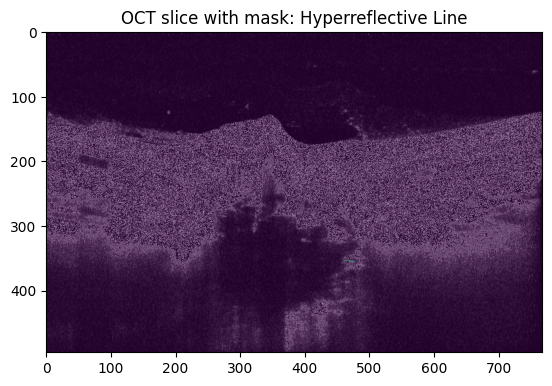

In [6]:
idx = randint(0, id_map.id.nunique())   # randomly choose an index

img = Image.open(paths_join(IMAGE_PATH, [id_map.loc[idx,'id']+'.png']))
img = np.asarray(img)
mask = np.load(paths_join(MASK_PATH, [id_map.loc[idx,'id']+'.npy']))

plt.imshow(img**2, cmap='binary')
plt.imshow(mask, alpha=.5)
plt.title('OCT slice with mask: %s' % id_map.loc[idx,'labelName'])
plt.show()

Note! <br></br>
VGG16 and AlexNet both require inputs with 3_channels (trained that way). <br>
It seems like the thing to do is just repeat the greyscale image 3 times along the 3rd dimension, so ok. 

In [36]:
class OpticDiscDrusenDataset(Dataset):
    ''' Makes the exported masks, labels and images into a torch Dataset
    for now, the transforms are kept very simple. '''

    def __init__(self, img_path, mask_path, x_set, transform=None, target_transform=None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.x_set = x_set
        self.transform = transform
        self.target_transform = target_transform
       
    def __len__(self):
        ''' x_set = x_train/test/val '''
        return len(self.x_set)
    
    def __getitem__(self, idx):

        if torch.is_tensor(idx):
            idx = idx.tolist()  # turns requested index numbers to a list

        #img = cv2.imread(os.path.join(self.img_path, self.x_set[idx]) + '.png')
        img = cv2.imread(os.path.join(self.img_path, self.x_set[idx]) + '.png')
        mask = np.load(os.path.join(self.mask_path, self.x_set[idx]) + '.npy')

        if self.transform:  # for images
            img = self.transform(img)
            #img = nn.functional.pad(input=img, pad=(0,0,8,8), mode='constant') # pad so that size is 512 x 768
        
        if self.target_transform:   # for masks (labels?)
            mask = self.target_transform(mask)
            #mask = nn.functional.pad(input=mask, pad=(0,0,8,8), mode='constant') # pad so that size is 512 x 768
    
        return img, mask
        
    

feature batch shape: torch.Size([64, 3, 256, 256])
labels batch shape: torch.Size([64, 1, 256, 256])
 -> [batch_size, n_channels, img_height, img_width]


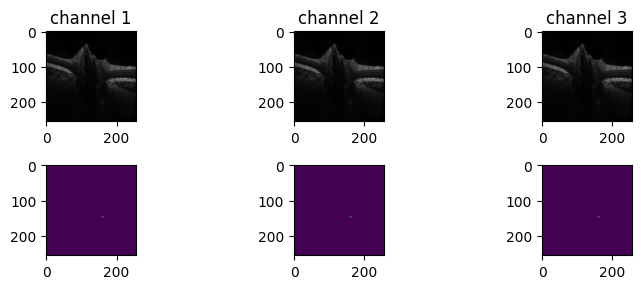

In [37]:
# Keeping this simple - just make them into tensors.

preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256,256))
    ])  # ToTensor first!

train_set = OpticDiscDrusenDataset(
    IMAGE_PATH, MASK_PATH, x_train, transform=preprocess, target_transform=preprocess)

val_set = OpticDiscDrusenDataset(
    IMAGE_PATH, MASK_PATH, x_val, transform=preprocess, target_transform=preprocess)

batch_size = 64

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)

# sanity check

train_features, train_labels = next(iter(train_loader))
print(f"feature batch shape: {train_features.size()}")
print(f"labels batch shape: {train_labels.size()}")
print(f" -> [batch_size, n_channels, img_height, img_width]")
n_channels = train_features.size()[1]

idx = randint(0, batch_size) 

f, ax = plt.subplots(2, n_channels, figsize=(8,3))
for i in range(n_channels):
    img = train_features[idx,i,:,:].squeeze()
    label = train_labels[idx].squeeze()
    ax[0,i].imshow(img, cmap='binary_r')
    ax[1,i].imshow(label)
    ax[0,i].set_title('channel %d' % (i+1))
plt.tight_layout()
plt.show()

# Model

In [50]:
'''model = smp.Unet(
    encoder_name='vgg16', 
    encoder_depth=5, 
    classes=3,
    encoder_weights='imagenet')'''
    
model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16', pretrained=True)
model.eval()

Using cache found in /Users/miaomiaoyu/.cache/torch/hub/pytorch_vision_v0.10.0


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [61]:
input_batch = train_features

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

with torch.no_grad():
    output = model(input_batch)
# Tensor of shape 1000, with confidence scores over Imagenet's 1000 classes
print(output[0])
# The output has unnormalized scores. To get probabilities, you can run a softmax on it.
probabilities = torch.nn.functional.softmax(output[0], dim=0)
print(probabilities)

tensor([-0.6611,  0.7851,  1.8979,  3.4100,  3.0969,  5.0582,  5.6514, -1.6584,
        -0.7627, -1.0821, -1.8165, -2.3130, -1.1272,  0.0872, -2.1768, -0.9513,
        -1.3213, -0.6382, -0.9594, -1.4123, -0.7293, -0.5997, -0.5782,  0.1069,
        -0.6090, -1.2475,  0.6318,  1.0833, -1.6948, -0.6498, -1.2283, -0.9797,
        -1.2372, -0.0842,  0.6408, -1.8596, -0.3902, -2.8169,  2.1080, -1.2832,
         2.0964,  0.3138, -0.5298,  0.8161,  0.2172, -1.5116,  0.0715, -0.2390,
        -1.2665, -0.6484,  1.0411,  1.1170,  0.7316,  1.0994,  0.4506, -1.1595,
        -0.5782, -1.2576,  3.0642,  0.0693,  0.2532, -1.1885, -0.9639,  0.0774,
         0.2689,  1.6483,  0.8360,  0.2039, -0.0493,  2.0135,  0.2932, -0.8400,
        -0.6254,  0.7025, -0.8176,  0.4736, -0.6142,  0.3111,  0.6273,  1.1569,
         0.9999,  0.8465,  0.4970,  0.2216, -0.8879, -0.0223,  0.0339, -1.4539,
        -1.5529, -2.1164, -2.9497, -1.5292, -1.6271, -2.4967,  0.3292, -3.0317,
        -0.9098, -2.2075, -2.2354, -0.63

TypeError: Invalid shape (1000,) for image data

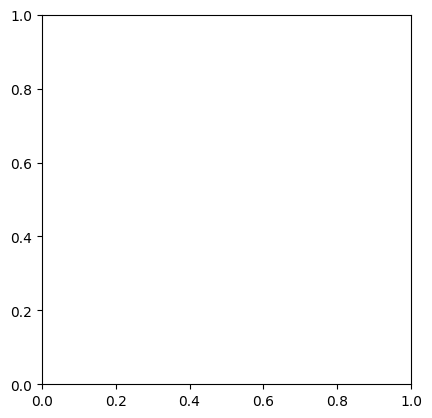

#### what does unfold do?

torch.Size([512, 768])
torch.Size([512, 3, 256])


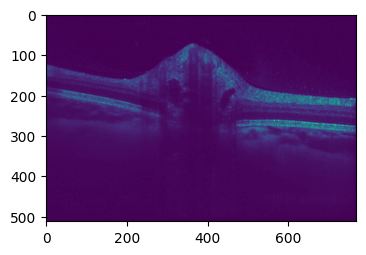

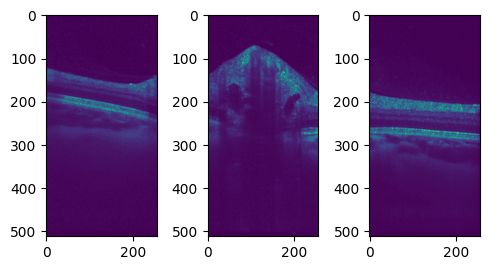

In [ ]:
print(img.shape)
print(img.unfold(1,256,256).shape)
# Extracts sliding local blocks from a batched input tensor.

plt.figure(figsize=(4,3))
plt.imshow(img)
plt.show()

f, ax = plt.subplots(1,3, figsize=(5,3))
ax[0].imshow(img.unfold(1,256,256)[:,0,:])
ax[1].imshow(img.unfold(1,256,256)[:,1,:])
ax[2].imshow(img.unfold(1,256,256)[:,2,:])
plt.tight_layout()
plt.show()